In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
user_data = pd.read_csv("./data_result/user_data.csv")
item_data = pd.read_csv("./data_result/item_data.csv")
data_train = pd.read_csv("./data_result/data_train.csv")
data_eval = pd.read_csv("./data_result/data_eval.csv")
data_test = pd.read_csv("./data_result/data_test.csv")
print(user_data.shape)
print(item_data.shape)


print(data_train.shape)
print(data_eval.shape)
print(data_test.shape)

(23291027, 6)
(620918, 3)
(8324819, 19)
(8595453, 19)
(8858710, 19)


In [3]:
# 划分数据集  predict_date:预测日期
def split_x_y(data, predict_date):
    end_date = "2014-12-1" + str(int(predict_date[-1])+1)
    #在此时间段购买商品的标签
    labels = user_data[(user_data["time"] >= predict_date)&(user_data["time"] < end_date)&(user_data["behavior_type"] == 4)][["user_id", "item_id"]].drop_duplicates()
    labels["is_buy"] = 1
    data = pd.merge(data, labels, how="left", on=["user_id", "item_id"])
    data["is_buy"] = data["is_buy"].fillna(0)
    x_train = data.drop(["user_id", "item_id", "item_category", "is_buy"], axis=1)
   
    y_train = data["is_buy"]
    print(end_date)
    return (x_train, y_train)     

In [4]:
# 训练集
(x_train,y_train) = split_x_y(data_train, "2014-12-17")
# 验证集
(x_eval,y_eval) = split_x_y(data_eval, "2014-12-18")
# 测试集 data_test
print(x_train.shape)
print(x_eval.shape)

2014-12-18
2014-12-19
(8324819, 16)
(8595453, 16)


In [5]:
import xgboost as xgb
xgb_train = xgb.DMatrix(x_train,y_train)
xgb_eval = xgb.DMatrix(x_eval,y_eval)
xbg_test = xgb.DMatrix(data_test.drop(["user_id", "item_id", "item_category"], axis=1))

In [6]:
print(y_train.value_counts())

0.0    8322828
1.0       1991
Name: is_buy, dtype: int64


## 测试模型最优迭代次数

In [7]:
xgb_params = {
    'objective': 'rank:pairwise', # 学习目标
    'eval_metric': 'auc', # 评价指标
    'gamma': 0.1, # 最小损失函数下降值
    'min_child_weight': 1.1, # 子集观察值的最小权重和
    'max_depth': 6, # 树的最大深度
    'lambda': 10, # L2正则化项
    'subsample': 0.7, # 树采样率
    'colsample_bytree': 0.7, # 特征采样率
    'eta': 0.01, # 学习率
    'tree_method':'exact', # 算法类别
    'seed':0
}

In [8]:
import time
a=time.time()
watchlist = [(xgb_train,'train'),(xgb_eval,'validate')]
model_xgb = xgb.train(xgb_params,xgb_train,num_boost_round=20,evals=watchlist,early_stopping_rounds=4)
#说明：设置early_stopping_rounds=10，当logloss在10轮迭代之内，都没有提升的话，就stop。
#如果说eval_metric有很多个指标，那就以最后一个指标为准。
print(time.time()-a)

[0]	train-auc:0.929708	validate-auc:0.880568
Multiple eval metrics have been passed: 'validate-auc' will be used for early stopping.

Will train until validate-auc hasn't improved in 4 rounds.
[1]	train-auc:0.942824	validate-auc:0.904791
[2]	train-auc:0.9452	validate-auc:0.913905
[3]	train-auc:0.949815	validate-auc:0.923705
[4]	train-auc:0.951467	validate-auc:0.926913
[5]	train-auc:0.952179	validate-auc:0.929498
[6]	train-auc:0.954761	validate-auc:0.933936
[7]	train-auc:0.954478	validate-auc:0.933783
[8]	train-auc:0.954214	validate-auc:0.933972
[9]	train-auc:0.953595	validate-auc:0.933187
[10]	train-auc:0.953706	validate-auc:0.933217
[11]	train-auc:0.95412	validate-auc:0.933703
[12]	train-auc:0.954506	validate-auc:0.934537
[13]	train-auc:0.954576	validate-auc:0.93462
[14]	train-auc:0.954781	validate-auc:0.934661
[15]	train-auc:0.955229	validate-auc:0.93625
[16]	train-auc:0.955446	validate-auc:0.936721
[17]	train-auc:0.955209	validate-auc:0.93648
[18]	train-auc:0.955764	validate-auc:0.9

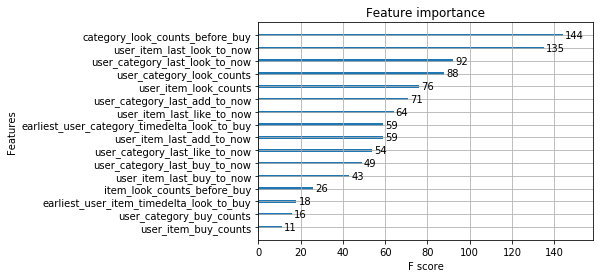

In [9]:
from xgboost import plot_importance
plot_importance(model_xgb)
plt.show()

In [10]:
best_iteration=model_xgb.best_iteration
print(best_iteration)  #最佳迭代次数
#model_xgb = xgb.train(params,xgb_train,num_boost_round=model_xgb.best_iteration)

19


In [13]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from xgboost import XGBClassifier,XGBRegressor
from sklearn.metrics import mean_absolute_error, make_scorer
import warnings
warnings.filterwarnings('ignore')

In [13]:
def mae_score(y_true, y_pred):
    return mean_absolute_error(np.exp(y_true), np.exp(y_pred))
mae_scorer = make_scorer(mae_score, greater_is_better=False)

## max_depth,min_child_weight最优参数

In [14]:
xgb_param_grid = {'max_depth': list(range(4,9))}#, 'min_child_weight': list((1,3,6))
grid = GridSearchCV(XGBRegressor(eta=0.1, num_boost_round=10, colsample_bytree=0.5, subsample=0.5,min_child_weight=1)
                    ,param_grid=xgb_param_grid, cv=3, scoring='r2')# scoring='r2' 决定系数（拟合优度）模型越好：r2→1,模型越差：r2→0

In [ ]:
grid.fit(x_train, y_train.values)

[13:49:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:49:29] WARNING: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[13:58:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:58:05] WARNING: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[14:06:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:06

In [ ]:
grid.grid_scores_, grid.best_params_, grid.best_score_

## 调节 gamma去降低过拟合风险

In [ ]:
xgb_param_grid = {'gamma':[ 0.1 * i for i in range(0,5)]}
grid = GridSearchCV(XGBRegressor(eta=0.1, num_boost_round=best_iteration, max_depth=8, min_child_weight=6,
                                        colsample_bytree=0.5, subsample=0.5),
                    param_grid=xgb_param_grid, cv=3, scoring='r2')
grid.fit(train_x, train_y.values)
grid.grid_scores_, grid.best_params_, grid.best_score_

## 调节样本采样方式 subsample 和 colsample_bytree

In [ ]:
xgb_param_grid = {'subsample':[ 0.1 * i for i in range(6,9)],
                      'colsample_bytree':[ 0.1 * i for i in range(6,9)]}


grid = GridSearchCV(XGBRegressor(eta=0.1, gamma=0.2, num_boost_round=best_iteration, max_depth=8, min_child_weight=6),
                    param_grid=xgb_param_grid, cv=3, scoring='r2')
grid.fit(train_x, train_y.values)
grid.grid_scores_, grid.best_params_, grid.best_score_

## 减小学习率

In [ ]:
xgb_param_grid = {'eta':[0.5,0.4,0.3,0.2,0.1,0.075,0.05,0.04,0.03]}
grid = GridSearchCV(XGBRegressor(num_boost_round=best_iteration, gamma=0.2, max_depth=8, min_child_weight=6,
                                        colsample_bytree=0.6, subsample=0.9),
                    param_grid=xgb_param_grid, cv=3, scoring='r2')

grid.fit(train_x, train_y.values)
grid.grid_scores_, grid.best_params_, grid.best_score_

## 选择树的个数

In [ ]:
xgb_param_grid = {'num_boost_round':[20,50,100,200,300,400,500]}
grid = GridSearchCV(XGBRegressor(gamma=0.2, max_depth=8, min_child_weight=6,eta=0.07,
                                        colsample_bytree=0.6, subsample=0.9),
                    param_grid=xgb_param_grid, cv=3, scoring='r2')
grid.fit(train_x, train_y.values)
grid.grid_scores_, grid.best_params_, grid.best_score_

## 最优模型

In [ ]:
model_xgb = XGBRegressor(num_boost_round=best_iteration, eta=0.07, gamma=0.2, max_depth=8, min_child_weight=6,
                                        colsample_bytree=0.6, subsample=0.9)
cv = model_xgb.kfold(train_x, train_y, nfold=5)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
eval_data = user_data[user_data["time"] < "2014-12-18"][["user_id", "item_id", "item_category"]].drop_duplicates()
print(len(eval_data))
eval_data["pred"] = model_xgb.predict(xgb.DMatrix(x_eval))
eval_data["pred"] = MinMaxScaler().fit_transform(eval_data["pred"].values.reshape(-1, 1))

In [ ]:
threshold = eval_data[["pred"]].sort_values(by="pred", ascending=False).iloc[550][0]
y_pred = eval_data["pred"].tolist()
for i in range(len(y_pred)):
    if y_pred[i] >= threshold:
        y_pred[i] = 1
    else:
        y_pred[i] = 0
y_eval = y_eval.tolist()

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
print("Validate set accuracy score: {:.4f}".format(accuracy_score(y_pred, y_eval)))
print("Validate set F1 score : {:.4f}".format(f1_score(y_pred, y_eval)))
confusion_matrix(y_pred, y_eval) 

In [ ]:
from sklearn.preprocessing import MinMaxScaler
item_list = item_data["item_id"].unique().tolist()
predict = data_test[["user_id", "item_id"]]
predict["label"] = model_xgb.predict(xbg_test)
predict["label"] = MinMaxScaler().fit_transform(predict["label"].values.reshape(-1, 1))
predict = predict[predict["item_id"].isin(item_list)].sort_values(by="label", ascending=False)

In [ ]:
result = predict.head(550)[["user_id", "item_id"]].drop_duplicates()
result.to_csv("submission.csv", index=False)